In [1]:
import numpy as np
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
import os

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow import keras

from tensorflow.keras.applications.resnet50 import preprocess_input
from keras.models import Sequential,load_model,Model
from keras.layers import Conv2D,MaxPool2D,AveragePooling2D,Dense,Flatten,ZeroPadding2D,BatchNormalization,Activation,Add,Input,Dropout,GlobalAveragePooling2D
from keras.initializers import glorot_uniform
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint,EarlyStopping,ReduceLROnPlateau
import warnings
warnings.filterwarnings(action='ignore')

2024-02-18 22:24:09.763422: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-18 22:24:09.880741: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-02-18 22:24:10.325485: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: :/home/venerable/miniconda3/envs/tensorflow/lib/
2024-02-18 22:24:10.325585: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnv

In [2]:
os.environ['KMP_DUPLICATE_LIB_OK']='True'

In [3]:
data_dir = "fruits_disease"
train_dir = data_dir + "/train_data"
valid_dir = data_dir + "/val_data"

In [4]:
diseases = os.listdir(train_dir)
nums = {}
for disease in diseases:
    nums[disease] = len(os.listdir(train_dir + '/' + disease))
img_per_class = pd.DataFrame(nums.values(), index=nums.keys(), columns=["no. of images"])
img_per_class

,no. of images
Bacterial Spot_peach,1838
Yellow Leaf Curl Virus_tmt,1961
Healthy_tmt,1926
Healthy_potato,1824
Cedar Apple Rust,1760
Cercospora Leaf Spot_corn,1642
Bacterial Spot_tmt,1702
Apple Scab,2017
Septoria Leaf Spot_tmt,1746
Northern Leaf Blight_corn,1908


NameError: name 'img_per_class' is not defined

In [9]:
train_datagen= ImageDataGenerator(shear_range=0.2,zoom_range=0.2,horizontal_flip=False,vertical_flip=False,fill_mode='nearest',width_shift_range=0.2,height_shift_range=0.2)
val_datagen=ImageDataGenerator()
train= train_datagen.flow_from_directory(train_dir,batch_size=32,target_size=(256,256),color_mode='rgb',class_mode='categorical',seed=42)
valid=val_datagen.flow_from_directory(valid_dir,batch_size=32,target_size=(256,256),color_mode='rgb',class_mode='categorical')

Found 53693 images belonging to 29 classes.
Found 12067 images belonging to 29 classes.


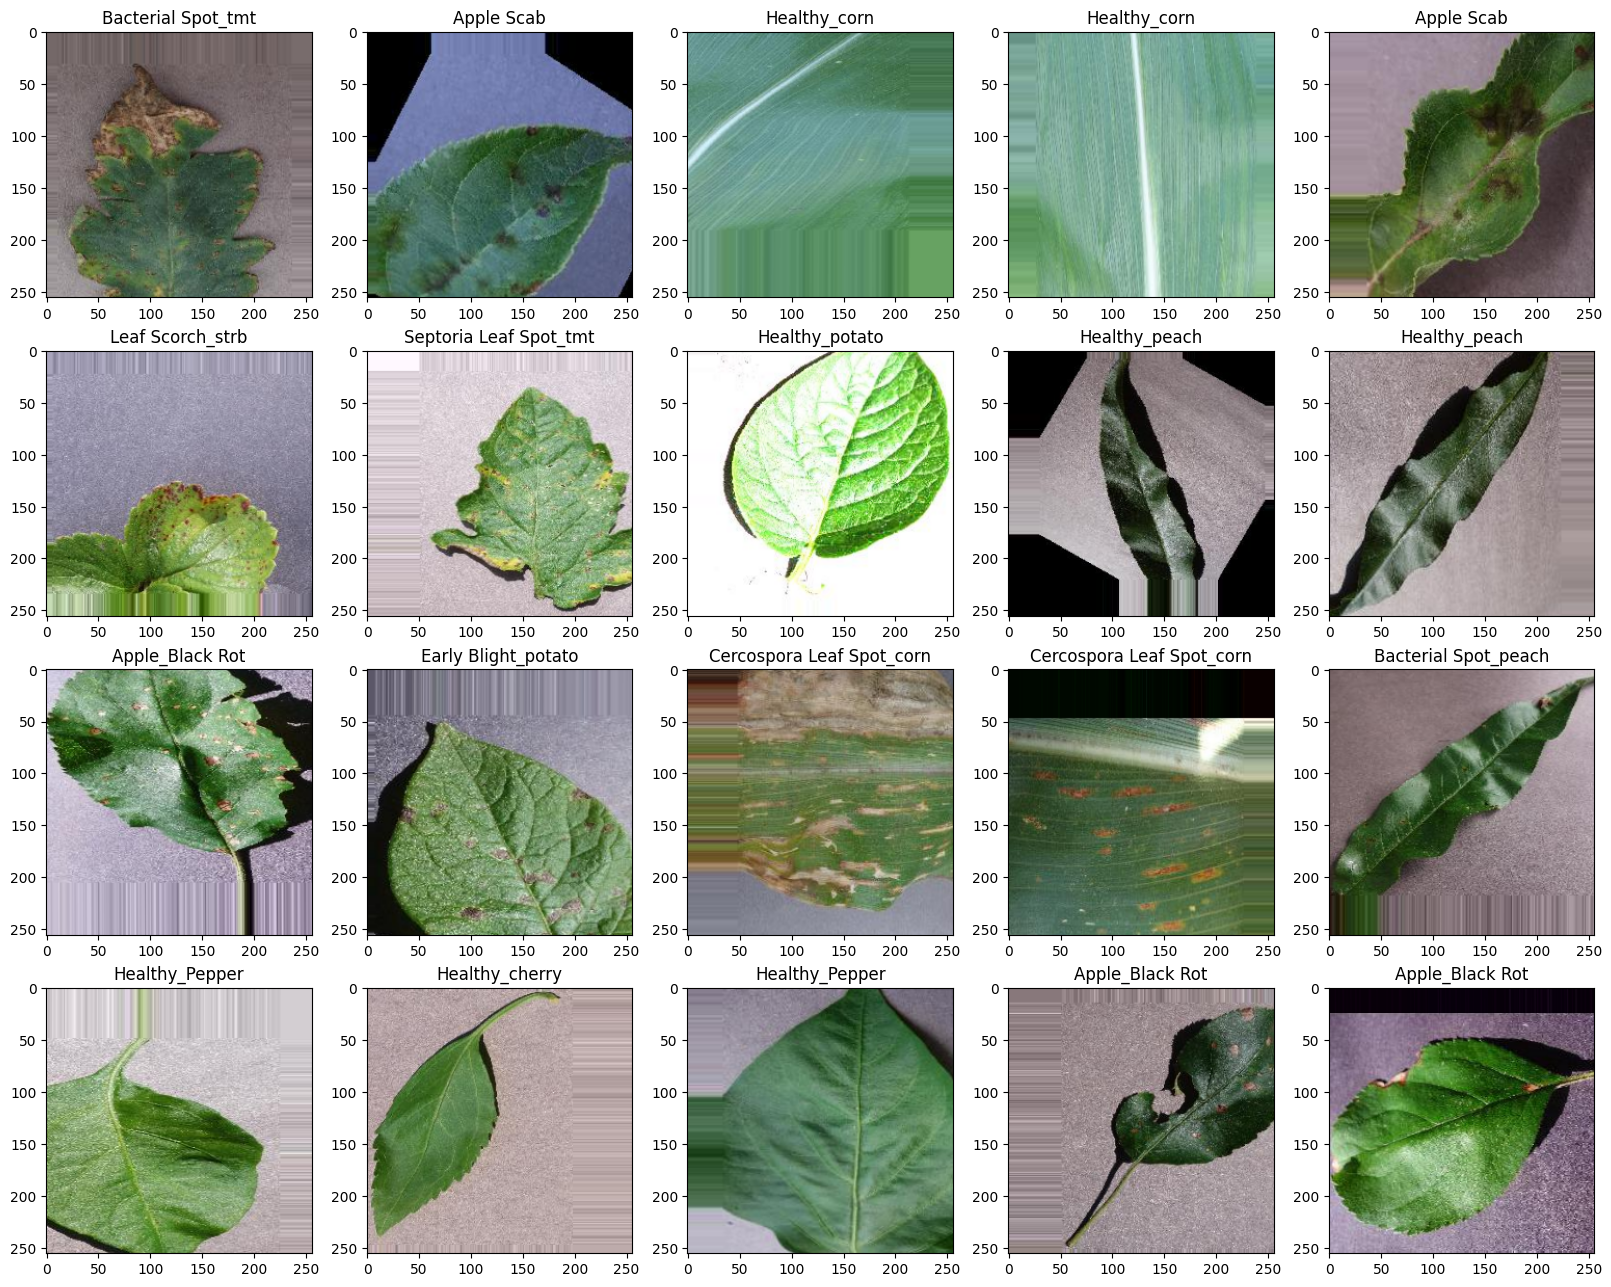

In [7]:
classes=list(train.class_indices.keys())
plt.figure(figsize=(20,20))
for X_batch, y_batch in train:
    for i in range(0,20):
        plt.subplot(5,5,i+1)
        plt.imshow(X_batch[i].astype(np.uint8))
        plt.title(classes[np.where(y_batch[i]==1)[0][0]])
    plt.show()
    break

In [8]:
base_model_tf=ResNet50(include_top=False,weights='imagenet',input_shape=(256,256,3),classes=29)
base_model_tf.trainable=False
pt=Input(shape=(256,256,3))
func=tensorflow.cast(pt,tensorflow.float32)
x=preprocess_input(func) 
model_resnet=base_model_tf(x,training=False)
model_resnet=GlobalAveragePooling2D()(model_resnet)
model_resnet=Dense(62,activation='relu')(model_resnet)
model_resnet=Dense(64,activation='relu')(model_resnet)
model_resnet=Dense(29,activation='softmax')(model_resnet)
Model_v1=Model(inputs=pt,outputs=model_resnet)
Model_v1.summary()
Model: "Model_v1"

2023-11-06 16:11:00.760438: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-06 16:11:00.777015: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-06 16:11:00.777214: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-11-06 16:11:00.777942: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.cast (TFOpLambda)        (None, 256, 256, 3)       0         
                                                                 
 tf.__operators__.getitem (S  (None, 256, 256, 3)      0         
 licingOpLambda)                                                 
                                                                 
 tf.nn.bias_add (TFOpLambda)  (None, 256, 256, 3)      0         
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                      

In [9]:
import tensorflow_addons as tfa
import tqdm
tqdm_callback = tfa.callbacks.TQDMProgressBar()

In [10]:
Model_v1.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history=Model_v1.fit(train,validation_data=valid,epochs=5,verbose=2,callbacks=[tqdm_callback])

Training:   0%|                                          0/5 ETA: ?s,  ?epochs/s

Epoch 1/5


0/1678                                                                ETA: ?s - 

Epoch 1/5


2023-11-06 16:11:10.721518: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-11-06 16:11:12.232449: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1678/1678 - 464s - loss: 0.3024 - accuracy: 0.9112 - val_loss: 0.1054 - val_accuracy: 0.9648 - 464s/epoch - 277ms/step
Epoch 2/5


0/1678                                                                ETA: ?s - 

Epoch 2/5
1678/1678 - 452s - loss: 0.0991 - accuracy: 0.9653 - val_loss: 0.0866 - val_accuracy: 0.9703 - 452s/epoch - 269ms/step
Epoch 3/5


0/1678                                                                ETA: ?s - 

Epoch 3/5
1678/1678 - 442s - loss: 0.0788 - accuracy: 0.9727 - val_loss: 0.0564 - val_accuracy: 0.9788 - 442s/epoch - 264ms/step
Epoch 4/5


0/1678                                                                ETA: ?s - 

Epoch 4/5
1678/1678 - 439s - loss: 0.0675 - accuracy: 0.9765 - val_loss: 0.0964 - val_accuracy: 0.9664 - 439s/epoch - 262ms/step
Epoch 5/5


0/1678                                                                ETA: ?s - 

Epoch 5/5
1678/1678 - 440s - loss: 0.0641 - accuracy: 0.9780 - val_loss: 0.0762 - val_accuracy: 0.9757 - 440s/epoch - 262ms/step


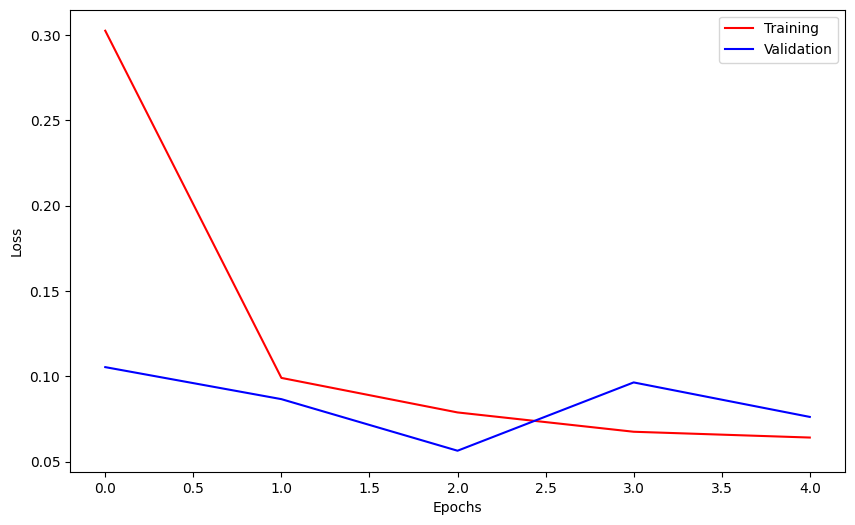

In [11]:
loss =history.history['loss']
val_loss =history.history['val_loss']
epochs = range(len(loss))
fig = plt.figure(figsize=(10,6))
plt.plot(epochs,loss,c="red",label="Training")
plt.plot(epochs,val_loss,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()



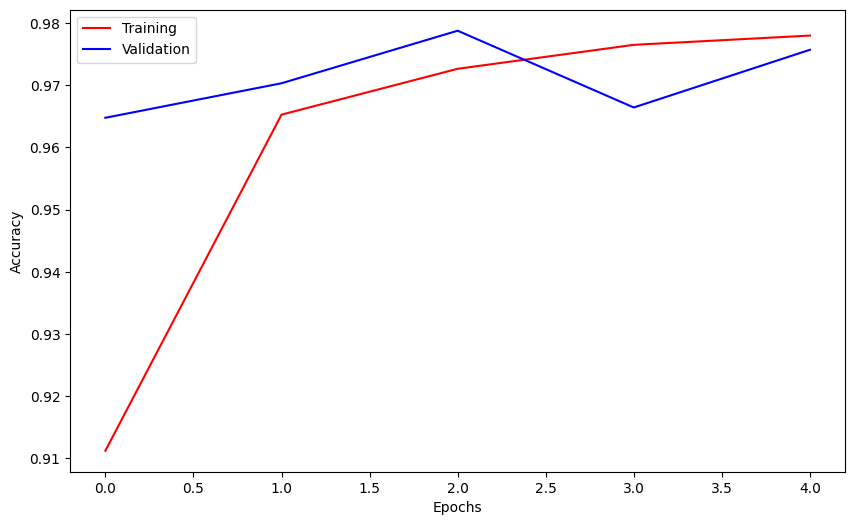

In [12]:
acc =history.history['accuracy']
val_acc =history.history['val_accuracy']
epochs = range(len(acc))
fig = plt.figure(figsize=(10,6))
plt.plot(epochs,acc,c="red",label="Training")
plt.plot(epochs,val_acc,c="blue",label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [22]:
Model_v1.save("Model1", '/saved_models',save_format=None)

INFO:tensorflow:Assets written to: Model1/assets


INFO:tensorflow:Assets written to: Model1/assets


In [19]:
from matplotlib import pyplot as plt
from sklearn.metrics import confusion_matrix , classification_report
import pandas as pd

AttributeError: module 'tensorflow.keras' has no attribute 'saving'

In [23]:
train.class_indices

{'Apple Scab': 0,
 'Apple_Black Rot': 1,
 'Bacterial Spot_Pepper': 2,
 'Bacterial Spot_peach': 3,
 'Bacterial Spot_tmt': 4,
 'Black Rot_grape': 5,
 'Cedar Apple Rust': 6,
 'Cercospora Leaf Spot_corn': 7,
 'Common Rust_corn': 8,
 'Early Blight_potato': 9,
 'Early Blight_tmt': 10,
 'Esca (Black Measles)_grape': 11,
 'Healthy_Apple': 12,
 'Healthy_Pepper': 13,
 'Healthy_cherry': 14,
 'Healthy_corn': 15,
 'Healthy_grape': 16,
 'Healthy_peach': 17,
 'Healthy_potato': 18,
 'Healthy_strb': 19,
 'Healthy_tmt': 20,
 'Late Blight_potato': 21,
 'Late Blight_tmt': 22,
 'Leaf Blight_grape': 23,
 'Leaf Scorch_strb': 24,
 'Northern Leaf Blight_corn': 25,
 'Powdery Mildew_cherry': 26,
 'Septoria Leaf Spot_tmt': 27,
 'Yellow Leaf Curl Virus_tmt': 28}

In [ ]:
import cv2
model = load_model('Model1')
from cv2 import imread
img1 = imread('image.JPG')
type(img1)



In [4]:
model = load_model('Model1')
converter = tf.lite.TFLiteConverter.from_keras_model(model=model)
model_tflite = converter.convert()
open("crops.tflite","wb").write(model_tflite)


INFO:tensorflow:Assets written to: /tmp/tmp19wjvxn9/assets


INFO:tensorflow:Assets written to: /tmp/tmp19wjvxn9/assets
2024-02-18 11:10:58.632518: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2024-02-18 11:10:58.632546: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2024-02-18 11:10:58.633044: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp19wjvxn9
2024-02-18 11:10:58.651868: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2024-02-18 11:10:58.651942: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /tmp/tmp19wjvxn9
2024-02-18 11:10:58.707507: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:354] MLIR V1 optimization pass is not enabled
2024-02-18 11:10:58.737121: I tensorflow/cc/saved_model/loader.cc:229] Restoring SavedModel bundle.
2024-02-18 11:10:59.124762: I tensorflow/cc/saved_model/loader.cc:213] Running initializatio

94497400

In [11]:
import cv2
img1 = cv2.resize(img1, (256,256))
img1.shape


NameError: name 'img1' is not defined

In [30]:
import numpy as np
img1_tensor = np.expand_dims(img1, axis=0)
img1_tensor.shape


(1, 256, 256, 3)

In [31]:
pred = model.predict(img1_tensor)

1/1 [==============================] - 1s 953ms/step


In [32]:
print(np.argmax(pred))

2


In [4]:
def process(img_path):
    img = imread(img_path)
    img = cv2.resize(img, (256,256))
    img_tensor = np.expand_dims(img, axis=0)
    fast_pred = Model1(img_tensor, training=False)
    k = np.argmax(fast_pred)
    
    return k



In [44]:
process('image3.JPG')

11

In [5]:
def process1(img):
    
    img = cv2.resize(img, (256,256))
    img_tensor = np.expand_dims(img, axis=0)
    fast_pred = Model1(img_tensor, training=False)
    k = np.argmax(fast_pred)
    
    return k



In [9]:

import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

In [10]:

actual = np.array(
    ['Cat', 'Dog', 'Horse', 'Cat', 'Dog', 'Cat', 'Dog',  'Horse', 'Horse', 'Cat'])
predicted = np.array(
    ['Cat', 'Dog', 'Dog', 'Cat', 'Dog', 'Cat', 'Dog',  'Horse', 'Horse', 'Dog'])

In [11]:

cm = confusion_matrix(actual,predicted)

In [13]:

print(classification_report(actual, predicted))

              precision    recall  f1-score   support

         Cat       1.00      0.75      0.86         4
         Dog       0.60      1.00      0.75         3
       Horse       1.00      0.67      0.80         3

    accuracy                           0.80        10
   macro avg       0.87      0.81      0.80        10
weighted avg       0.88      0.80      0.81        10



In [65]:
import numpy as np
import gradio as gr

def process1(img):
    
    img1 = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) 
    img2 = cv2.resize(img1, (256,256))
    img_tensor = np.expand_dims(img2, axis=0)
    fast_pred = model(img_tensor, training=False)
    k = np.argmax(fast_pred)
    
    
    return k

demo = gr.Interface(
    fn=process1,
    inputs=[gr.Image()],
    outputs=[ "number"],
)
demo.launch()

Running on local URL:  http://127.0.0.1:7867

To create a public link, set `share=True` in `launch()`.


In [62]:
import streamlit as st
from PIL import Image
import numpy as np

# Define the process1 function
def process1(img):
    try:
        # Example processing code (replace with your actual image processing code)
        img_array = np.array(img)
        # Here you should have your model prediction code
        # For demonstration, we will just return a random number
        prediction = np.random.randint(0, 29)  # Random integer between 0 and 28
        return prediction
    except Exception as e:
        st.error(f"An error occurred during image processing: {e}")
        return None

# Dictionary mapping prediction numbers to labels
class_to_label = {
    0: 'Apple Scab',
    1: 'Apple_Black Rot',
    2: 'Bacterial Spot_Pepper',
    3: 'Bacterial Spot_peach',
    4: 'Bacterial Spot_tmt',
    5: 'Black Rot_grape',
    6: 'Cedar Apple Rust',
    7: 'Cercospora Leaf Spot_corn',
    8: 'Common Rust_corn',
    9: 'Early Blight_potato',
    10: 'Early Blight_tmt',
    11: 'Esca (Black Measles)_grape',
    12: 'Healthy_Apple',
    13: 'Healthy_Pepper',
    14: 'Healthy_cherry',
    15: 'Healthy_corn',
    16: 'Healthy_grape',
    17: 'Healthy_peach',
    18: 'Healthy_potato',
    19: 'Healthy_strb',
    20: 'Healthy_tmt',
    21: 'Late Blight_potato',
    22: 'Late Blight_tmt',
    23: 'Leaf Blight_grape',
    24: 'Leaf Scorch_strb',
    25: 'Northern Leaf Blight_corn',
    26: 'Powdery Mildew_cherry',
    27: 'Septoria Leaf Spot_tmt',
    28: 'Yellow Leaf Curl Virus_tmt'
}

# Streamlit interface
st.title("Image Classification")
uploaded_image = st.file_uploader("Upload an image", type=["jpg", "jpeg", "png"])

if uploaded_image is not None:
    try:
        # Open and display the uploaded image
        image = Image.open(uploaded_image)
        st.image(image, caption='Uploaded Image.', use_column_width=True)

        # Process the image and get the prediction
        prediction = process1(image)
        if prediction is not None:
            predicted_class = class_to_label.get(prediction, "Unknown")
            st.write("Predicted Class:", predicted_class)
    except Exception as e:
        st.error(f"An unexpected error occurred: {e}")


Unexpected exception formatting exception. Falling back to standard exception


Traceback (most recent call last):
  File "/home/venerable/miniconda3/envs/tensorflow/lib/python3.9/site-packages/IPython/core/interactiveshell.py", line 3548, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "/tmp/ipykernel_4787/3594358913.py", line 1, in <module>
    import streamlit as st
  File "/home/venerable/miniconda3/envs/tensorflow/lib/python3.9/site-packages/streamlit/__init__.py", line 56, in <module>
    from streamlit.delta_generator import DeltaGenerator as _DeltaGenerator
  File "/home/venerable/miniconda3/envs/tensorflow/lib/python3.9/site-packages/streamlit/delta_generator.py", line 71, in <module>
    from streamlit.elements.widgets.checkbox import CheckboxMixin
  File "/home/venerable/miniconda3/envs/tensorflow/lib/python3.9/site-packages/streamlit/elements/widgets/checkbox.py", line 52, in <module>
    class CheckboxMixin:
  File "/home/venerable/miniconda3/envs/tensorflow/lib/python3.9/site-packages/streamlit/elements/widgets/checkbox.py", 

In [60]:
pip install streamlit

/bin/bash: /home/venerable/miniconda3/envs/tensorflow/lib/libtinfo.so.6: no version information available (required by /bin/bash)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.4/8.4 MB 4.5 MB/s eta 0:00:00m eta 0:00:010:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.4/196.4 kB 13.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 13.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.3/38.3 MB 27.5 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 18.6 MB/s eta 0:00:00m eta 0:00:010:01:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 83.0/83.0 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 14.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.19.6
    Uninstalling protobuf-3.19.6:
      Successfully uninstalled protobuf-3.19.6
ERROR: pip's dependency resolver does not currently take into account all the packages that are 

In [54]:
import gradio as gr

def classify_text(text):
    # Example function that returns a string label based on input text
    if "dog" in text.lower():
        return "Animal: Dog"
    elif "cat" in text.lower():
        return "Animal: Cat"
    else:
        return "Animal: Unknown"

output_string = gr.outputs.Label()

demo = gr.Interface(
    fn=classify_text,
    inputs=gr.inputs.Textbox(lines=5, label="Enter text"),
    outputs=output_string
)

demo.launch()


AttributeError: module 'gradio' has no attribute 'outputs'

In [39]:
class_to_label = {
    0: 'Apple Scab',
    1: 'Apple_Black Rot',
    2: 'Bacterial Spot_Pepper',
    3: 'Bacterial Spot_peach',
    4: 'Bacterial Spot_tmt',
    5: 'Black Rot_grape',
    6: 'Cedar Apple Rust',
    7: 'Cercospora Leaf Spot_corn',
    8: 'Common Rust_corn',
    9: 'Early Blight_potato',
    10: 'Early Blight_tmt',
    11: 'Esca (Black Measles)_grape',
    12: 'Healthy_Apple',
    13: 'Healthy_Pepper',
    14: 'Healthy_cherry',
    15: 'Healthy_corn',
    16: 'Healthy_grape',
    17: 'Healthy_peach',
    18: 'Healthy_potato',
    19: 'Healthy_strb',
    20: 'Healthy_tmt',
    21: 'Late Blight_potato',
    22: 'Late Blight_tmt',
    23: 'Leaf Blight_grape',
    24: 'Leaf Scorch_strb',
    25: 'Northern Leaf Blight_corn',
    26: 'Powdery Mildew_cherry',
    27: 'Septoria Leaf Spot_tmt',
    28: 'Yellow Leaf Curl Virus_tmt'
}
for i in class_to_label:   
    print(class_to_label[i])



Apple Scab
Apple_Black Rot
Bacterial Spot_Pepper
Bacterial Spot_peach
Bacterial Spot_tmt
Black Rot_grape
Cedar Apple Rust
Cercospora Leaf Spot_corn
Common Rust_corn
Early Blight_potato
Early Blight_tmt
Esca (Black Measles)_grape
Healthy_Apple
Healthy_Pepper
Healthy_cherry
Healthy_corn
Healthy_grape
Healthy_peach
Healthy_potato
Healthy_strb
Healthy_tmt
Late Blight_potato
Late Blight_tmt
Leaf Blight_grape
Leaf Scorch_strb
Northern Leaf Blight_corn
Powdery Mildew_cherry
Septoria Leaf Spot_tmt
Yellow Leaf Curl Virus_tmt


In [13]:
base_model_tf=ResNet50(include_top=False,weights='imagenet',input_shape=(256,256,3),classes=29)
base_model_tf.trainable=False
pt=Input(shape=(256,256,3))
func=tensorflow.cast(pt,tensorflow.float32)
x=preprocess_input(func) 
model_resnet=base_model_tf(x,training=False)
model_resnet=GlobalAveragePooling2D()(model_resnet)
model_resnet=Dense(62,activation='relu')(model_resnet)
model_resnet=Dense(64,activation='relu')(model_resnet)
model_resnet=Dense(29,activation='softmax')(model_resnet)
Model_v2=Model(inputs=pt,outputs=model_resnet)
Model_v2.summary()
Model: "Model_v2"

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 tf.cast_1 (TFOpLambda)      (None, 256, 256, 3)       0         
                                                                 
 tf.__operators__.getitem_1   (None, 256, 256, 3)      0         
 (SlicingOpLambda)                                               
                                                                 
 tf.nn.bias_add_1 (TFOpLambd  (None, 256, 256, 3)      0         
 a)                                                              
                                                                 
 resnet50 (Functional)       (None, 8, 8, 2048)        23587712  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0   

In [ ]:
Model_v2.compile(optimizer='Adam',loss='categorical_crossentropy',metrics=['accuracy'])
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)
history=Model_v2.fit(train,validation_data=valid,epochs=10,verbose=2,callbacks=[tqdm_callback])

Training:   0%|                                                                                               …

Epoch 1/20


0/1678                                                                                                        …

Epoch 1/20


2023-11-05 08:37:49.444938: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8100
2023-11-05 08:37:50.937432: I tensorflow/stream_executor/cuda/cuda_blas.cc:1614] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.


1678/1678 - 463s - loss: 0.3054 - accuracy: 0.9094 - val_loss: 0.1351 - val_accuracy: 0.9548 - 463s/epoch - 276ms/step
Epoch 2/20


0/1678                                                                                                        …

Epoch 2/20
1678/1678 - 461s - loss: 0.0969 - accuracy: 0.9668 - val_loss: 0.0961 - val_accuracy: 0.9654 - 461s/epoch - 275ms/step
Epoch 3/20


0/1678                                                                                                        …

Epoch 3/20
1678/1678 - 459s - loss: 0.0794 - accuracy: 0.9721 - val_loss: 0.0781 - val_accuracy: 0.9745 - 459s/epoch - 274ms/step
Epoch 4/20


0/1678                                                                                                        …

Epoch 4/20
1678/1678 - 464s - loss: 0.0641 - accuracy: 0.9777 - val_loss: 0.1022 - val_accuracy: 0.9672 - 464s/epoch - 276ms/step
Epoch 5/20


0/1678                                                                                                        …

Epoch 5/20
1678/1678 - 461s - loss: 0.0622 - accuracy: 0.9786 - val_loss: 0.0577 - val_accuracy: 0.9805 - 461s/epoch - 275ms/step
Epoch 6/20


0/1678                                                                                                        …

Epoch 6/20
1678/1678 - 439s - loss: 0.0559 - accuracy: 0.9813 - val_loss: 0.0554 - val_accuracy: 0.9804 - 439s/epoch - 262ms/step
Epoch 7/20


0/1678                                                                                                        …

Epoch 7/20
1678/1678 - 458s - loss: 0.0543 - accuracy: 0.9814 - val_loss: 0.0733 - val_accuracy: 0.9757 - 458s/epoch - 273ms/step
Epoch 8/20


0/1678                                                                                                        …

Epoch 8/20
1678/1678 - 452s - loss: 0.0480 - accuracy: 0.9831 - val_loss: 0.0847 - val_accuracy: 0.9739 - 452s/epoch - 269ms/step
Epoch 9/20


0/1678                                                                                                        …

Epoch 9/20
1678/1678 - 460s - loss: 0.0436 - accuracy: 0.9854 - val_loss: 0.0546 - val_accuracy: 0.9829 - 460s/epoch - 274ms/step
Epoch 10/20


0/1678                                                                                                        …

Epoch 10/20
1678/1678 - 450s - loss: 0.0441 - accuracy: 0.9853 - val_loss: 0.0902 - val_accuracy: 0.9731 - 450s/epoch - 268ms/step
Epoch 11/20


0/1678                                                                                                        …

Epoch 11/20


Traceback (most recent call last):
  File "/home/venerable/miniconda3/envs/tensorflow/lib/python3.9/site-packages/gradio/queueing.py", line 427, in call_prediction
    output = await route_utils.call_process_api(
  File "/home/venerable/miniconda3/envs/tensorflow/lib/python3.9/site-packages/gradio/route_utils.py", line 232, in call_process_api
    output = await app.get_blocks().process_api(
  File "/home/venerable/miniconda3/envs/tensorflow/lib/python3.9/site-packages/gradio/blocks.py", line 1484, in process_api
    result = await self.call_function(
  File "/home/venerable/miniconda3/envs/tensorflow/lib/python3.9/site-packages/gradio/blocks.py", line 1106, in call_function
    prediction = await anyio.to_thread.run_sync(
  File "/home/venerable/miniconda3/envs/tensorflow/lib/python3.9/site-packages/anyio/to_thread.py", line 33, in run_sync
    return await get_asynclib().run_sync_in_worker_thread(
  File "/home/venerable/miniconda3/envs/tensorflow/lib/python3.9/site-packages/anyio/_b